In [1]:
import os
os.environ["JAVA_HOME"] = "C:/Java/jdk1.8.0_261"
os.environ["SPARK_HOME"] = "D:/Spark/spark-3.0.1-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt

In [4]:
df = spark.read.csv('Iris.csv', inferSchema=True, header=True)
df_features = df.select(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
df_features.show()

+-------------+------------+-------------+------------+-----------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+-------------+------------+-------------+------------+-----------+
|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
|          5.4|         3.9|          1.7|         0.4|Iris-setosa|
|          4.6|         3.4|          1.4|         0.3|Iris-setosa|
|          5.0|         3.4|          1.5|         0.2|Iris-setosa|
|          4.4|         2.9|          1.4|         0.2|Iris-setosa|
|          4.9|         3.1|          1.5|         0.1|Iris-setosa|
|          5.4|         3.7|          1.5|         0.2|Iris-setosa|
|          4.8|         3.4|          1.6|      

In [5]:
# encoding categorical data column "Species" with integer column "SpeciesIndex"

indexer = StringIndexer(inputCol="Species", outputCol="SpeciesIndex")
indexed = indexer.fit(df_features).transform(df_features)

In [6]:
# selecting the relevant columns for K-Means clustering

df_final = indexed.select(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'SpeciesIndex'])
df_final.show()

+-------------+------------+-------------+------------+------------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|SpeciesIndex|
+-------------+------------+-------------+------------+------------+
|          5.1|         3.5|          1.4|         0.2|         0.0|
|          4.9|         3.0|          1.4|         0.2|         0.0|
|          4.7|         3.2|          1.3|         0.2|         0.0|
|          4.6|         3.1|          1.5|         0.2|         0.0|
|          5.0|         3.6|          1.4|         0.2|         0.0|
|          5.4|         3.9|          1.7|         0.4|         0.0|
|          4.6|         3.4|          1.4|         0.3|         0.0|
|          5.0|         3.4|          1.5|         0.2|         0.0|
|          4.4|         2.9|          1.4|         0.2|         0.0|
|          4.9|         3.1|          1.5|         0.1|         0.0|
|          5.4|         3.7|          1.5|         0.2|         0.0|
|          4.8|         3.4|      

In [7]:
# Preparing the dataframe for the K-Means. All features need to be vectors in a single column

trainingData=df_final.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
trainingData.show()

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|  0.0|
|[4.9,3.0,1.4,0.2]|  0.0|
|[4.7,3.2,1.3,0.2]|  0.0|
|[4.6,3.1,1.5,0.2]|  0.0|
|[5.0,3.6,1.4,0.2]|  0.0|
|[5.4,3.9,1.7,0.4]|  0.0|
|[4.6,3.4,1.4,0.3]|  0.0|
|[5.0,3.4,1.5,0.2]|  0.0|
|[4.4,2.9,1.4,0.2]|  0.0|
|[4.9,3.1,1.5,0.1]|  0.0|
|[5.4,3.7,1.5,0.2]|  0.0|
|[4.8,3.4,1.6,0.2]|  0.0|
|[4.8,3.0,1.4,0.1]|  0.0|
|[4.3,3.0,1.1,0.1]|  0.0|
|[5.8,4.0,1.2,0.2]|  0.0|
|[5.7,4.4,1.5,0.4]|  0.0|
|[5.4,3.9,1.3,0.4]|  0.0|
|[5.1,3.5,1.4,0.3]|  0.0|
|[5.7,3.8,1.7,0.3]|  0.0|
|[5.1,3.8,1.5,0.3]|  0.0|
+-----------------+-----+
only showing top 20 rows



In [8]:
# Train a k-means model.
kmeans = KMeans().setK(3).setSeed(123457)
model = kmeans.fit(trainingData)

# Making predictions
predictions = model.transform(trainingData)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette Score = " + str(silhouette))

Silhouette Score = 0.7354567373091194


In [9]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.006 3.418 1.464 0.244]
[5.9016129  2.7483871  4.39354839 1.43387097]
[6.85       3.07368421 5.74210526 2.07105263]


In [10]:
K = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score_list = []

for k in K:
    kmeans = KMeans().setK(k).setSeed(123457)
    model = kmeans.fit(trainingData)
    predictions = model.transform(trainingData)
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    Score_list.append(silhouette)
    print("K = "+ str(k))
    print("Silhouette Score = " + str(silhouette))

K = 2
Silhouette Score = 0.8501515983265806
K = 4
Silhouette Score = 0.6720731409257744
K = 5
Silhouette Score = 0.6706851820952463
K = 6
Silhouette Score = 0.5383681330070867
K = 7
Silhouette Score = 0.5373436803439575
K = 8
Silhouette Score = 0.5201944844225137
K = 9
Silhouette Score = 0.5206541193624177
K = 10
Silhouette Score = 0.412318808489034
K = 11
Silhouette Score = 0.4672638777684366
K = 12
Silhouette Score = 0.45092769842548164


No handles with labels found to put in legend.


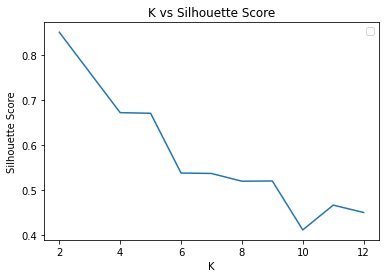

In [11]:
# Plotting graph
plt.plot(K, Score_list)
plt.legend()
plt.title('K vs Silhouette Score')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

plt.show()

# k = 2 gives the best performance, Silhouette = 0.85